# urllib的使用

## urllib库包含的模块

### request
这是最基本的HTTP请求模块，可以模拟请求的发送。就像在浏览器里输入网址然后按下回车一样，只需要给库方法传入URL以及额外的参数，就可以模拟实现发送请求的过程了。

### error
异常处理模块。如果出现请求异常，那么我们可以捕获这些异常，然后进行重试或其他操作以保证程序运行不会意外终止。

### parse
一个工具模块。提供了很多URL的处理方法，例如拆分，解析，合并等。

### robotparser
主要用来识别网站的robots.txt文件，然后判断哪些网站可以爬，哪些不可约，它用到较少。

## 1.发送请求

### urlopen
urllib.request模块提供了最基本的构造HTTP请求的方法，利用这个模块可以模拟浏览器的请求发起过程，同时它还具有处理**验证授权（Authentication)** ,**重定向（Redirection)** ,**浏览器Cookie** 以及其他一些功能。

In [ ]:
# 爬取Python官网源代码
import urllib.request

response = urllib.request.urlopen('http://www.python.org')
print(response.read().decode('utf-8'))

In [ ]:
#响应的类型为HTTPResposne,主要包含read,readinto,getheader,getheaders,fileno等方法，msg,version,status,reason,debuglevel,closed等属性
print(type(response))
#获取响应状态码
print(response.status)
#获取响应头信息
print(response.getheaders())

print(response.getheader('Server'))

In [ ]:
#urllib.request.urlopen的API：
#urllib.request.urlopen(url,data=None,[timeout,]*,cafile=None,capath=None,cadefault=False,context=None)

#data 参数
    #data参数是可选的。在添加该参数时，需要使用bytes方法将参数转化为字节流编码格式的内容，即bytes类型。另外，如果传递了这个参数，请求就不是
    #（续）GET而是POST了
    
import urllib.request
import urllib.parse

data = bytes(urllib.parse.urlencode({'name':'zzz','age':18}),encoding='utf-8')
response = urllib.request.urlopen('http://www.httpbin.org/post',data=data)
print(response.read().decode('utf-8'))

In [ ]:
#timeout 参数用于设置超时时间，单位为秒，如果请求超出这个时间还没有响应则会抛出异常。如果不指定参数，则会使用全局默认时间。这个参数支持HTTP，HTTPS,FTP请求

import urllib.request
import socket 
import urllib.error
try:
    
    response = urllib.request.urlopen('https://www.httpbin.org/get',timeout=0.1)

except urllib.error.URLError as e:
    if isinstance(e.reason,socket.timeout):
        print('time out')

In [ ]:
#Request
    
    #利用urlopen方法可以发起最基本的请求，但它那几个简单的参数并不足以构建一个完整的请求。如果需要往请求中加入Header等信息，就得利用更强大的Request类来构建请求了。
    
import urllib.request
#构造Request对象，一方面可以将请求独立成一个对象，另一方面可以更加丰富和灵活地配置参数
request = urllib.request.Request('https://python.org')
response = urllib.request.urlopen(request) #参数变为了一个Request对象
print(response.read().decode('utf-8'))

In [ ]:
#Request类构造方法：
# class urllib.request.Request(url,data=None,headers={},origin_req_host=None,unverifiable=False,method=None)
from urllib import request,parse

url = 'https://www.httpbin.org/post'

headers={
    'User-Agent':'Mozilla/4.0(compatible;MSIE 5.5;Windows NT)',
    'Host':'www.httpbin.org'
}


#还可以通过add_header方法添加header
dict = {'name':'zyz','age':18}
data=bytes(parse.urlencode(dict),encoding='utf-8')
req = request.Request(url=url,data=data,headers=headers,method='POST')
response=request.urlopen(req)
print(response.read().decode('utf-8'))

### 高级用法

对于一些高级的操作（Cookie处理，代理设置等），我们需要更强大的工具。

#### Handler
Handler可以理解为各种处理器，有专门处理登录验证的，处理Cookie的，代理设置的。利用这些Handler，我们几乎可以实现HTTP请求中所有的功能

首先介绍一些urllib.request里面的BaseHandler类,这是其他所有Handler类的父类，它提供了最基本的方法。

会有各种Handler子类继承BaseHandler类，例如：
    HTTPDefaultErrorHandler 用于处理HTTP响应错误，所有错误都会抛出HTTPError类型的异常
    HTTPRedirectHandler 用于处理重定义
    HTTPCookieProcessor 用于处理Cookie
    ProxyHandler 用于设置代理，代理默认为空
    HTTPPasswordMgr 用于管理密码，它维护着用户密码的对照表
    HTTPBasicAuthHandler 用于管理认证，如果一个链接在打开时需要认证，那么可以用这个类来解决认证问题

#### OpenerDirector

我们称之为Opener。urlopen方法实际上就是urllib库为我们提供的一个Opener。但是为了实现更高级的功能，就需要深入一层配置，使用更底层的实例来完成操作，所以要使用Opener类。

Opener类可以提供open方法，该方法返回的响应类型和urlopen方法如出一辙，

### Handler与Opener

两者关系，简单来说就是利用Handler类来构建Opener类。下面是几个例子。

In [ ]:
# *验证 
# 访问某些网站时候，如https://ssr3.scrape.center,可能会弹出认证窗口，遇Ba到这种情况就表示这个网站开启了基本身份验证，爬虫要想请求这样的界面
# 就需要借助 HTTPBasicAuthHandler模块完成

from urllib.request import HTTPPasswordMgrWithDefaultRealm as httppass,HTTPBasicAuthHandler as AuthHandler,build_opener

from urllib.error import URLError

username='admin'
password='admin'
url='https://ssr3.scrape.center/'
p= httppass()
p.add_password(None,url,username,password)
auth_handler=AuthHandler(p)
opener = build_opener(auth_handler)

try :
    result = opener.open(url)
    html=result.read().decode('utf-8')
    print(html)
except URLError as e:
    print(e.reason)


#这里先实例化了一个HTTPBasciAuthHandler对象 auth_handler，其参数是HTTPPasswordMgrWithDefaultRealm对象，它利用add_password方法添加用户名和密码
#这样就创立了一个用来处理验证的Handler类
#然后将auth_handler类作为参数传入build_opener方法，构建一个Opener，这个Opener在发送请求时就相当于已经验证成功了
#最后利用Opener类中的open方法打开链接，即可完成验证

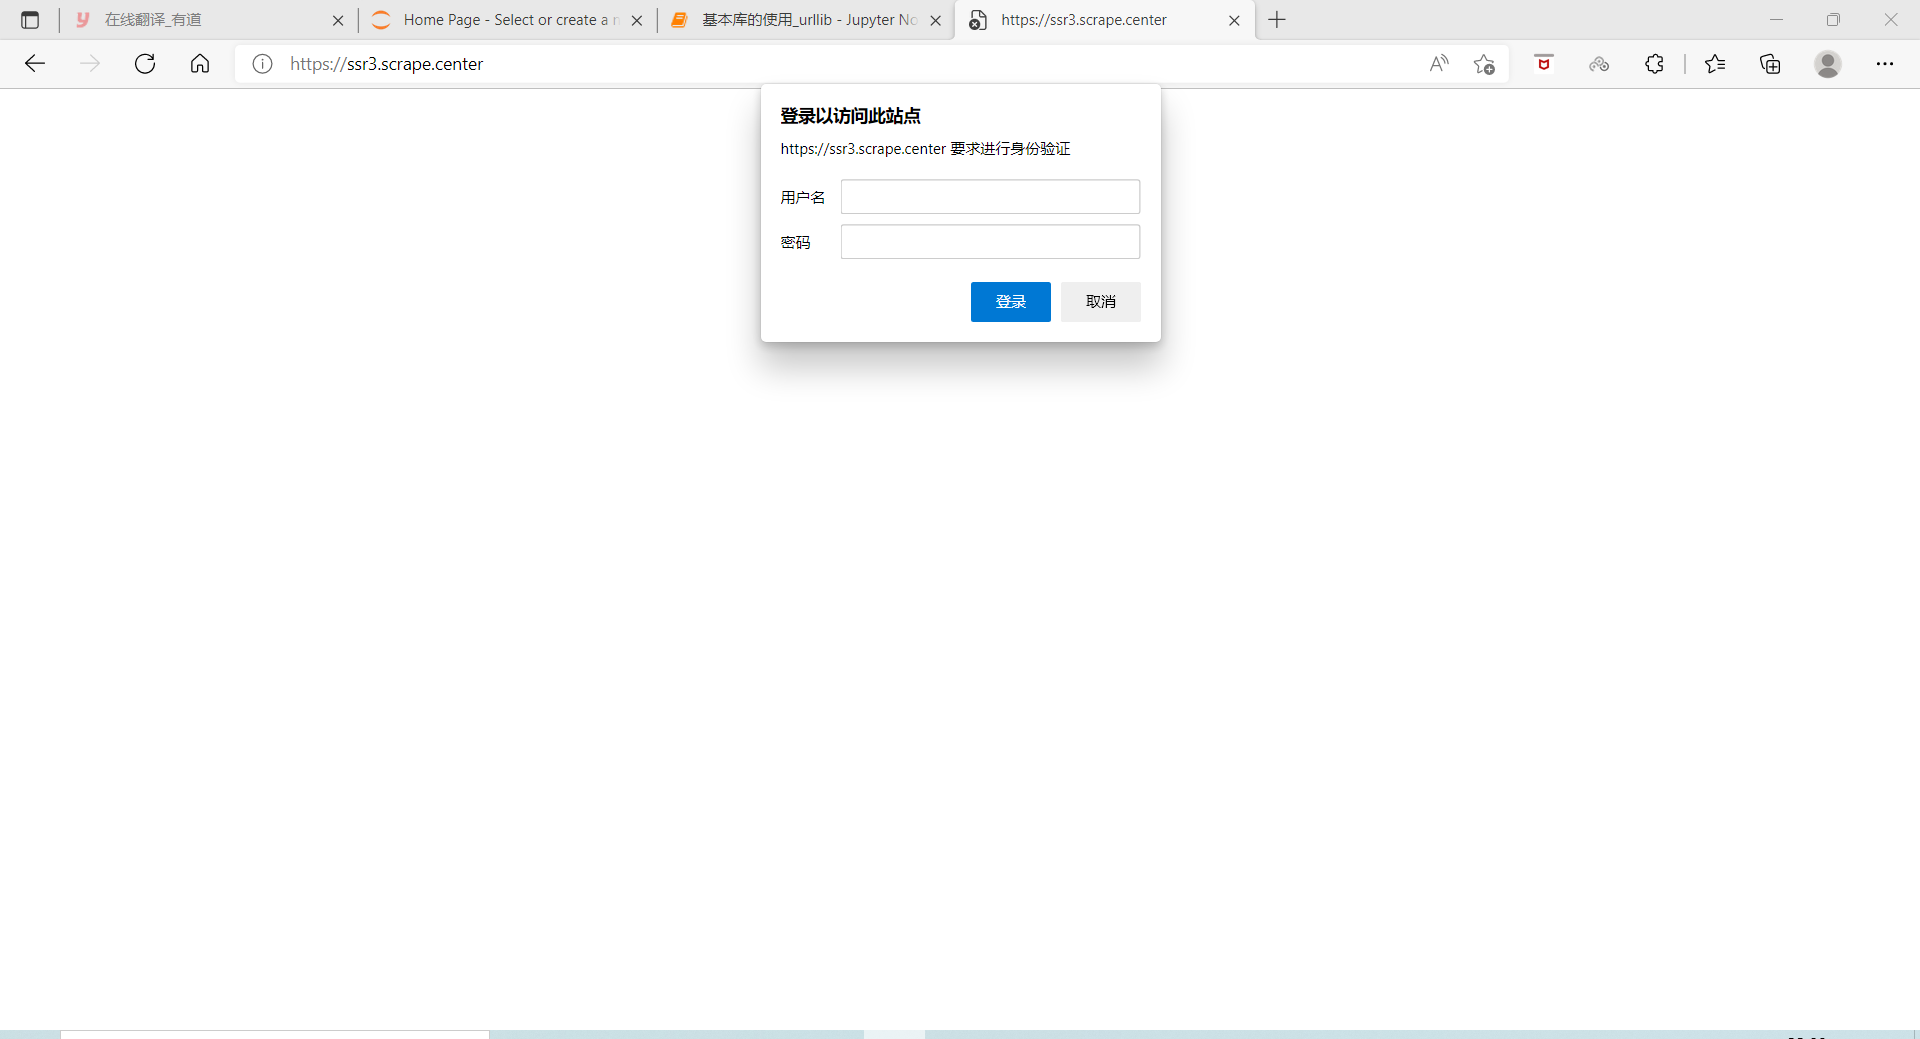

In [ ]:
#代理

#做爬虫时，免不了使用代理，如果要添加代理，可以这样做：

from urllib.request import ProxyHandler,build_opener
from urllib.error import URLError

#键名是协议类型，键值是代理链接，可以添加多个代理
proxy_handler = ProxyHandler({
    'http':'代理ip',
    'https':'代理ip'
})
opener = build_opener(proxy_handler)

try:
    response=opener.open('url')
    print(response.read().decode('utf-8'))
except URLError as e:
    print(e.reason)

In [ ]:
# Cookie

## 2.处理异常

urllib库中的error模块定义了由request模块产生的异常。当出现问题时，request模块便会抛出error模块中定义的异常

注意：捕获错误时候先捕获子类的再捕获父类的

### URLError
URLError类来自urllib库的error模块，继承来自OSError类，是error异常模块的基类，由request模块产生的异常都可以通过捕获这个类来处理。
它有一个reason的属性，即返回错误的原因。

In [ ]:
from urllib.error import URLError
import urllib.request

try:
    response = urllib.request.urlopen('https://z.com/404',timeout=0.1)
except URLError as e:
    print(e.reason)

### HTTPError

HTTPError是URLError的子类，专门用来处理HTTP请求错误，例如请求失败等。它有如下3个属性：


1.code：返回HTTP状态码，例如404表示页面不存在，500表示服务器内部错误等。

2.reason:同父类一样，用于返回错误的原因。

3.headers：返回请求头

In [ ]:
from urllib.error import HTTPError
import urllib
try:
    response = urllib.request.urlopen('https://cuiqingcai.com/404')
except HTTPError as e:
    print(e.code,e.reason,e.headers)

## 3.解析链接

urllib库里还提供了parse模块，这个模块定义了处理URL的标准接口，例如实现URL各部分的抽取，合并以及链接转换。

In [5]:
#urlparse
#该方法可以实现URL的识别和分段。了解就行
#实例:

import urllib.parse

result=urllib.parse.urlparse('https://www.baidu.com/index.html;user?id=5#commwnt')
print(type(result))
print(result)

<class 'urllib.parse.ParseResult'>
ParseResult(scheme='https', netloc='www.baidu.com', path='/index.html', params='user', query='id=5', fragment='commwnt')


In [7]:
#urlunparse

#这个方法用于构造URL,这个方法接受的参数是一个可迭代对象，其长度必须是6！！！

import urllib.parse

data=['https','www.baidu.com','index.html','user','a=6','comment']
print(urllib.parse.urlunparse(data))

https://www.baidu.com/;user?a=6#comment


In [8]:
# urlsplit
#这个方法与urlparse方法非常相似，只不过它不在单独解析params这一部分(params会合并到path中)，只返回五个结果

import urllib.parse

result=urllib.parse.urlsplit('https://www.baidu.com/index.html;user?id=5#commwnt')
print(type(result))
print(result)

<class 'urllib.parse.SplitResult'>
SplitResult(scheme='https', netloc='www.baidu.com', path='/index.html;user', query='id=5', fragment='commwnt')


In [9]:
# urlunsplit
#与urlunparse方法类似，只不过传入参数为五个

import urllib.parse

data=['https','www.baidu.com','user','a=6','comment']
print(urllib.parse.urlunsplit(data))

https://www.baidu.com/user?a=6#comment


In [1]:
#urljoin

#urlunparse,urlunsplit都可以完成链接的合并，不过前提都是必须有特定长度的对象，链接的每一部分都要清晰分开

#除了这两种方法，还有一种生成链接的方法，是urljoin。我们可以提供一个base_url，作为该方法的第一个参数，将新的连接作为第二个参数。
#urljoin方法会分析base_url的scheme，netloc和path这3个内容，并对新链接缺失的部分进行补充，最后返回结果(新连接补充后的)。

import urllib.parse as parse
print(parse.urljoin('https://www.baidu.com','FAQ.html'))


#base_url提供三项内容:scheme,netloc,path。如果新连接不存在这三项，就给予补充，如果存在，就使用新连接的，base_url不起作用

https://www.baidu.com/FAQ.html


In [1]:
#urlencode

#这个方法在构造GET请求参数的时候非常有用

import urllib.parse as parse
params={
    'name':'zyz',
    'age':18
}
base_url='https://www.zyz.com?'
url=base_url + parse.urlencode(params)
print(url)

#urlencode方法非常常用，有时为了更加方便地构造参数，我们会事先用字典将参数表示出来，然后将字典转化为URL参数时，只需要调用该方法即可。

https://www.zyz.com?name=zyz&age=18


In [2]:
#parse_qs

#有了序列化，必然有反序列化。利用parse_qs方法，可以将一串GET请求参数转回字典(键值为列表)

import urllib.parse
query = 'name=zyz&age=18'
print(urllib.parse.parse_qs(query))

{'name': ['zyz'], 'age': ['18']}


In [3]:
#parse_qsl

#parse_qsl方法用于将参数转化为由元组组成的列表
import urllib.parse
query = 'name=zyz&age=18'
print(urllib.parse.parse_qsl(query))

[('name', 'zyz'), ('age', '18')]


In [2]:
#quote
#该方法可以将内容转化为URL编码的格式。
#当URL带有中文参数时，有可能导致乱码问题，此时用quote方法可以将中文字符转化为URL编码

import urllib.parse

keyword='壁纸'
url='https://www.baidu.com/s?wd='+urllib.parse.quote(keyword)
print(url)
# unquote
#这个方法可以将URL解码

import urllib.parse

print(urllib.parse.unquote(url))

https://www.baidu.com/s?wd=%E5%A3%81%E7%BA%B8
https://www.baidu.com/s?wd=壁纸
